# Лабораторная работа номер 5

Выполнил: Стрельцов Илья Дмитриевич Б9122-01.03.02мкт

## Импорты

In [12]:
import io
from pathlib import Path

import ipywidgets as widgets
import kagglehub
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import display, clear_output
from PIL import Image
from sklearn.metrics import roc_auc_score, roc_curve
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [2]:
SEED = 5
IMG_SIZE = 150
BATCH_SIZE = 32
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DATASET = 'sanikamal/horses-or-humans-dataset'

print(f"Using device: {DEVICE}")

Using device: cpu


## Загрузка данных

### Скачивание датасета

In [3]:
dataset_path = Path(kagglehub.dataset_download(DATASET))
print(f"Dataset downloaded to: {dataset_path}")

train_path = dataset_path / 'horse-or-human' / 'train'
val_path = dataset_path / 'horse-or-human' / 'validation'

Dataset downloaded to: C:\Users\drumo\.cache\kagglehub\datasets\sanikamal\horses-or-humans-dataset\versions\1


### Первичное исследование среднего и стандартного отклонения

In [4]:
def compute_mean_std(dataset_path, img_size=150, batch_size=32):
    temp_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor()
    ])

    temp_dataset = datasets.ImageFolder(root=dataset_path, transform=temp_transform)
    temp_loader = DataLoader(temp_dataset, batch_size=batch_size, shuffle=False)

    mean = 0.0
    std = 0.0
    total_images = 0

    for images, _ in temp_loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images += batch_samples

    mean /= total_images
    std /= total_images

    return mean.tolist(), std.tolist()

In [5]:
train_mean, train_std = compute_mean_std(train_path, IMG_SIZE, BATCH_SIZE)
print(f"Computed mean: {train_mean}")
print(f"Computed std: {train_std}")

Computed mean: [0.5510269403457642, 0.5145178437232971, 0.49468734860420227]
Computed std: [0.22408099472522736, 0.20414331555366516, 0.20988696813583374]


### Загрузка преобразованных данных в тензоры

In [6]:
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=train_mean, std=train_std)
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=train_mean, std=train_std)
])

# Загрузка данных
train_dataset = datasets.ImageFolder(root=train_path, transform=train_transform)
validation_dataset = datasets.ImageFolder(root=val_path, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Классы: {train_dataset.classes}")
print(f"Соответствие классов индексам: {train_dataset.class_to_idx}")
print(f"Тренировочные примеры: {len(train_dataset)}")
print(f"Валидационные примеры: {len(validation_dataset)}")

Классы: ['horses', 'humans']
Соответствие классов индексам: {'horses': 0, 'humans': 1}
Тренировочные примеры: 1027
Валидационные примеры: 256


## Модель

In [9]:
class HorseHumanCNN(nn.Module):
    def __init__(self):
        super(HorseHumanCNN, self).__init__()

        # Сверточные слои
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        # Max pooling
        self.pool = nn.MaxPool2d(2, 2)

        # Полносвязные слои
        self.fc1 = nn.Linear(128 * 9 * 9, 512)
        self.fc2 = nn.Linear(512, 1)

        # Dropout для регуляризации
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Сверточные блоки
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))

        # Выравнивание для полносвязных слоев
        x = x.view(-1, 128 * 9 * 9)

        # Полносвязные слои
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

In [11]:
model = HorseHumanCNN().to(DEVICE)
model

HorseHumanCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=10368, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

## Функции для ROC-AUC

In [13]:
def train_model(
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        epochs=25
):
    train_losses = []
    val_losses = []
    train_aucs = []
    val_aucs = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        all_train_preds = []
        all_train_labels = []

        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE).float().unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Предсказания для AUC
            preds = torch.sigmoid(outputs)
            all_train_preds.extend(preds.cpu().detach().numpy())
            all_train_labels.extend(labels.cpu().numpy())

        model.eval()
        val_loss = 0.0
        all_val_preds = []
        all_val_labels = []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE).float().unsqueeze(1)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                preds = torch.sigmoid(outputs)
                all_val_preds.extend(preds.cpu().numpy())
                all_val_labels.extend(labels.cpu().numpy())

        # Метрики
        train_loss = running_loss / len(train_loader)
        val_loss = val_loss / len(val_loader)

        train_auc = roc_auc_score(all_train_labels, all_train_preds)
        val_auc = roc_auc_score(all_val_labels, all_val_preds)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_aucs.append(train_auc)
        val_aucs.append(val_auc)

        if (epoch + 1) % 5 == 0:
            print(f'Epoch {epoch+1}/{epochs}:')
            print(f'  Train Loss: {train_loss:.4f}, Train AUC: {train_auc:.4f}')
            print(f'  Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}')

    return train_losses, val_losses, train_aucs, val_aucs

def plot_metrics(train_losses, val_losses, train_aucs, val_aucs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Loss
    ax1.plot(train_losses, label='Training Loss')
    ax1.plot(val_losses, label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # AUC
    ax2.plot(train_aucs, label='Training AUC')
    ax2.plot(val_aucs, label='Validation AUC')
    ax2.set_title('ROC-AUC')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('AUC')
    ax2.legend()
    ax2.grid(True)
    ax2.axhline(y=0.6, color='r', linestyle='--', label='Target AUC = 0.6')

    plt.tight_layout()
    plt.show()

## Обучение

In [14]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses, val_losses, train_aucs, val_aucs = train_model(
    model,
    train_loader,
    validation_loader,
    criterion,
    optimizer,
    epochs=30
)

Epoch 5/30:
  Train Loss: 0.1534, Train AUC: 0.9850
  Val Loss: 0.8000, Val AUC: 0.9884
Epoch 10/30:
  Train Loss: 0.0687, Train AUC: 0.9966
  Val Loss: 2.4776, Val AUC: 0.9487
Epoch 15/30:
  Train Loss: 0.0315, Train AUC: 0.9994
  Val Loss: 1.0620, Val AUC: 0.9859
Epoch 20/30:
  Train Loss: 0.0192, Train AUC: 0.9998
  Val Loss: 2.0755, Val AUC: 0.9786
Epoch 25/30:
  Train Loss: 0.0818, Train AUC: 0.9961
  Val Loss: 1.4577, Val AUC: 0.9759
Epoch 30/30:
  Train Loss: 0.0366, Train AUC: 0.9988
  Val Loss: 2.7565, Val AUC: 0.9485


### Сохранение модели

In [18]:
torch.save(model.state_dict(), 'horse_human_cnn.pth')

In [15]:
final_auc = val_aucs[-1]
print(f"ROC-AUC: {final_auc:.4f}")

print("Win" if final_auc > 0.6 else "Defeat")

ROC-AUC: 0.9485
Win


## Визуализация

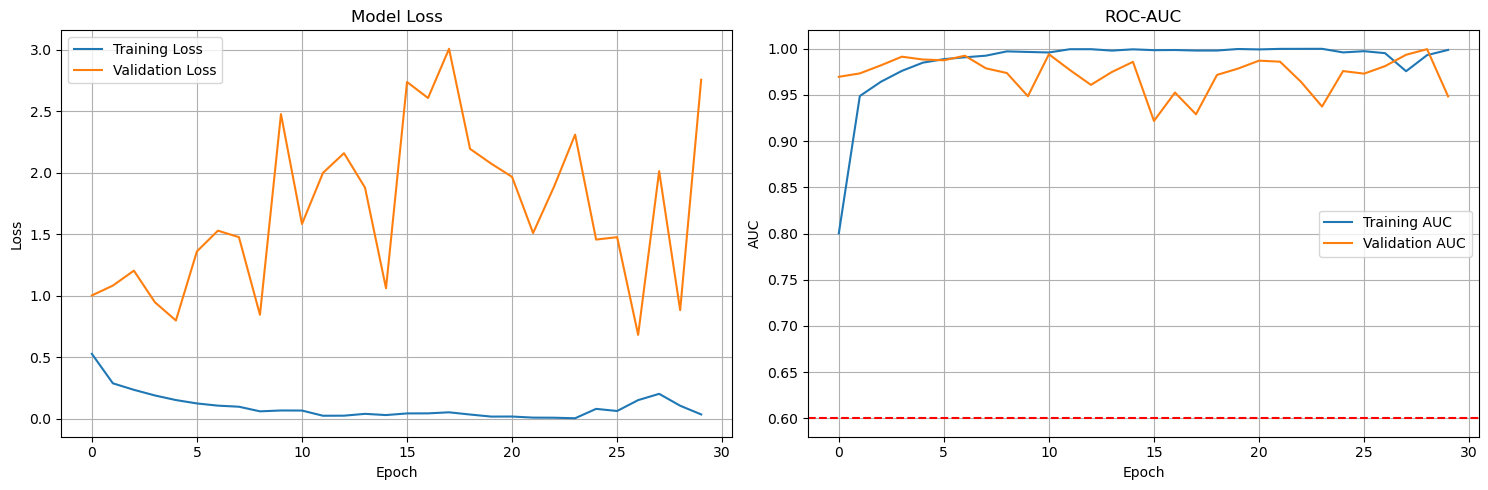

In [16]:
plot_metrics(train_losses, val_losses, train_aucs, val_aucs)

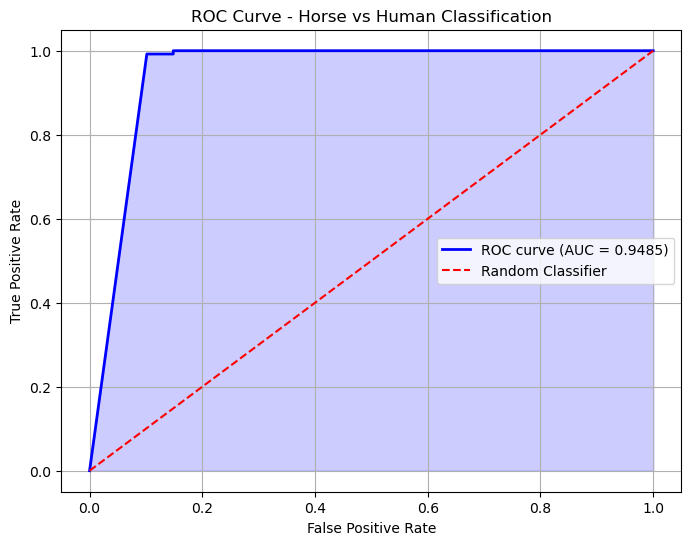

ROC-AUC Score: 0.9485


In [17]:
def evaluate_roc_auc(model, val_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE).float().unsqueeze(1)

            outputs = model(images)
            preds = torch.sigmoid(outputs)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # ROC-AUC и ROC curve
    auc_score = roc_auc_score(all_labels, all_preds)
    fpr, tpr, thresholds = roc_curve(all_labels, all_preds)

    # Визуализация ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', linewidth=2, label=f'ROC curve (AUC = {auc_score:.4f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
    plt.fill_between(fpr, tpr, alpha=0.2, color='blue')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Horse vs Human Classification')
    plt.legend()
    plt.grid(True)
    plt.show()

    return auc_score, fpr, tpr, thresholds

auc_score, fpr, tpr, thresholds = evaluate_roc_auc(model, validation_loader)
print(f"ROC-AUC Score: {auc_score:.4f}")

## Интерфейс

Подгрузка обученной модели.

In [19]:
model.load_state_dict(torch.load('horse_human_cnn.pth', map_location=DEVICE))
model.eval()

HorseHumanCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=10368, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

Вспомогательные функции и описание виджетов

In [22]:
def preprocess_image(image_bytes):
    """Предобработка загруженного изображения"""
    image = Image.open(io.BytesIO(image_bytes)).convert('RGB')

    transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    image_tensor = transform(image).unsqueeze(0)
    return image_tensor, image

def predict_image(image_tensor):
    """Предсказание для одного изображения"""
    with torch.no_grad():
        image_tensor = image_tensor.to(DEVICE)
        output = model(image_tensor)
        probability = torch.sigmoid(output).cpu().numpy()[0][0]
    return probability



### Описание Виджетов

In [37]:
upload = widgets.FileUpload(
    accept='.jpg,.jpeg,.png',
    multiple=False,
    description='Загрузить изображение',
    style={'description_width': 'initial'}
)

classify_btn = widgets.Button(
    description="Проверить 🐴/👤",
    button_style='success',
    icon='search',
    layout=widgets.Layout(width='200px', height='40px')
)

clear_btn = widgets.Button(
    description="Очистить",
    button_style='warning',
    icon='eraser',
    layout=widgets.Layout(width='100px', height='40px')
)

output = widgets.Output()

def on_classify_click(btn):
    with output:
        clear_output()

        if not upload.value:
            print("Сначала загрузите изображение")
            return

        try:
            # Получение и обработка изображения
            if hasattr(upload.value, '__getitem__'):
                first_item = upload.value[0]
                if hasattr(first_item, 'get'):
                    uploaded_image = first_item.get('content')
                else:
                    uploaded_image = getattr(first_item, 'content', None)
            else:
                print("Невозможно выполнить upload.value как для коллекции")
                return

            if uploaded_image is None:
                print("Изображение не найдено")
                return

            image_tensor, original_image = preprocess_image(uploaded_image)

            probability = predict_image(image_tensor)

            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

            ax1.imshow(original_image)
            ax1.axis('off')
            ax1.set_title('Загруженное изображение', fontsize=14, fontweight='bold')

            classes = ['Лошадь', 'Человек']
            colors = ['#FF9999', '#66B2FF']
            probabilities = [1 - probability, probability]

            bars = ax2.bar(classes, probabilities, color=colors, alpha=0.8,
                          edgecolor='black', linewidth=1.5)
            ax2.set_ylim(0, 1)
            ax2.set_title('Вероятность классификации', fontsize=11)
            ax2.set_ylabel('Вероятность', fontweight='bold')
            ax2.grid(True, alpha=0.3)

            for bar, prob in zip(bars, probabilities):
                height = bar.get_height()
                ax2.text(bar.get_x() + bar.get_width()/2, height + 0.01,
                        f'{prob:.3f}', ha='center', va='bottom',
                        fontweight='bold', fontsize=12)

            human_prob = probability
            horse_prob = 1 - probability
            dominant_class = "HUMAN" if human_prob > horse_prob else "HORSE"
            dominant_prob = max(human_prob, horse_prob)

            plt.tight_layout()
            plt.show()

            # Вывод текстового результата
            print("**Результат классификации**")
            print(f"**Предсказание:** {dominant_class}")
            print(f"**Уверенность:** {dominant_prob:.3f}")
            print(f"Человек - вероятность: {human_prob:.3f}")
            print(f"Лошадь - вероятность: {horse_prob:.3f}")

            if dominant_prob > 0.7:
                print("**Высокая уверенность в предсказании**")
            elif dominant_prob > 0.5:
                print("**Средняя уверенность в предсказании**")
            else:
                print("**Низкая уверенность в предсказании**")

        except Exception as e:
            print(f"Ошибка в обработке изображения: {str(e)}")

def on_clear_click(btn):
    upload.value = []
    with output:
        clear_output()
    print("Загрузка очищена. Подготовка к новому изображению завершена.")

# Привязка событий
classify_btn.on_click(on_classify_click)
clear_btn.on_click(on_clear_click)

# Создание layout
button_box = widgets.HBox([classify_btn, clear_btn],
                         layout=widgets.Layout(justify_content='center', margin='10px'))


### Отображение интерфейса

In [38]:
display(upload)
display(button_box)
display(output)

FileUpload(value=(), accept='.jpg,.jpeg,.png', description='Загрузить изображение')

Output()